# Imports

In [1]:
import sys
sys.path.append('..')
from src.utils import get_pre_call_window_metrics, calculate_post_call_price_direction, preprocess_text, adjust_to_trading_day, load_and_prepare_prices, load_and_combine_transcripts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve

The purpose of this analysis is to predict the price direction (up or down) of a stock after the earnings call based on sentiment scores, in addition to volatility over different time periods before the call. We have done EDA in several notebooks looking at sentiment scores based on the earnings call transcripts. We have done basic processing to the text, but have intentionally kept it minimal so that this analysis can be served as a base line to compare further approaches. 

Since the text of the calls are what we are focused on, and there are many different ways to handle the nuances of the calls and how much variation there can be from call to call and company to company, I want to have a basic approach to compare to as I experiment with different approaches. 

# Get the Data

In [2]:
# These represent tickers that do not have transcript text in our data or do not have the full history
tickers_to_drop = ['A1G.DE', 'GLUX', 'SWN.DE', 'JET.NE', 'SRFM', 'MESA', 'SNCY', 'ULCC', 'JETMF', 'SAVE', 'ATSG']

# Load stock prices
prices_df = load_and_prepare_prices('../data/raw/historical_prices.csv', tickers_to_drop)

# Load transcript data
combined_transcripts_df = load_and_combine_transcripts('../data/raw/', tickers_to_drop)

# Adjust the earnings call dates to the nearest trading day since some of the transcript dates fall on the weekend
trading_dates = set(prices_df['date'])
combined_transcripts_df['date'] = combined_transcripts_df['date'].apply(lambda x: adjust_to_trading_day(x, trading_dates))

# Merge the stock price data with the adjusted transcript data
combined_df = prices_df.merge(combined_transcripts_df, how='left', on=['symbol', 'date'])

# Create Metrics

Time Window

Creating metrics using different time windows before the earnings call. There can be a lot of variation of stock price volatility leading up to a call and can vary a lot between the timeframe. We are grabbing the period before the call and not after since this would introduce bias into our model.

In [3]:
# Defining different time windows for (before, after) the earnings call date
time_frames_before = [1, 5, 10, 30]

# Get the tickers
tickers = combined_df['symbol'].unique()
metrics_dfs = []

# Loop over the tickers and time frames
for ticker in tickers:
    for days_before in time_frames_before:
        ticker_df = combined_df[combined_df['symbol'] == ticker]
        temp_df = get_pre_call_window_metrics(ticker_df, ticker, days_before)
        metrics_dfs.append(temp_df)

# Combine
metrics_df = pd.concat(metrics_dfs)
metrics_df.sort_values(by=['original_call_date', 'symbol'], inplace=True)
metrics_df['post_call_price_direction'] = calculate_post_call_price_direction(combined_df, metrics_df, post_call_days=1)
metrics_df = metrics_df.rename(columns={'adjusted_call_date': 'date', 'symbol':'ticker'}).drop(columns=['original_call_date'])


In [4]:
metrics_df.head()

,date,ticker,timeframe,volatility,pre_call_price_percent_change,post_call_price_direction
0,2018-04-12,DAL,1_days_before,0.000000,0.000000,0
0,2018-04-12,DAL,5_days_before,0.580259,-2.073820,0
0,2018-04-12,DAL,10_days_before,0.977398,-0.923965,0
0,2018-04-12,DAL,30_days_before,1.610998,-9.047535,0
0,2018-04-18,UAL,1_days_before,0.000000,0.000000,0
...,...,...,...,...,...,...
22,2023-10-31,JBLU,30_days_before,0.177489,-9.482759,0
22,2023-11-02,ALGT,1_days_before,0.000000,0.000000,1
22,2023-11-02,ALGT,5_days_before,1.387528,-3.891561,1
22,2023-11-02,ALGT,10_days_before,2.096210,-8.314794,1


In [5]:
metrics_df['post_call_price_direction'].value_counts()

post_call_price_direction
0    444
1    384
Name: count, dtype: int64

Sentiment Score

In [6]:
# Preprocess the earnings call content - using a pretty basic processing approach here
# Will increase the complexity of the processing in the next iteration
combined_transcripts_df['cleaned_content'] = combined_transcripts_df['content'].apply(preprocess_text)

# Sentiment analysis using TextBlob
combined_transcripts_df['sentiment'] = combined_transcripts_df['cleaned_content'].apply(lambda text: TextBlob(text).sentiment)
combined_transcripts_df['polarity'] = combined_transcripts_df['sentiment'].apply(lambda x: x.polarity)
combined_transcripts_df['subjectivity'] = combined_transcripts_df['sentiment'].apply(lambda x: x.subjectivity)
combined_transcripts_df['word_count'] = combined_transcripts_df['cleaned_content'].apply(lambda x: len(x.split()))

# Drop the columns that are not needed
combined_transcripts_df.drop(['content','cleaned_content','sentiment','quarter','year'], axis = 1, inplace = True)
combined_transcripts_df.rename(columns = {'symbol':'ticker'}, inplace = True)

Combine

In [7]:
# combine the metrics with the transcripts
df = combined_transcripts_df.merge(metrics_df, on = ['date','ticker'], how='left')

In [8]:
df.isnull().sum()

ticker                           0
date                             0
polarity                         0
subjectivity                     0
word_count                       0
timeframe                        0
volatility                       0
pre_call_price_percent_change    0
post_call_price_direction        0
dtype: int64

In [9]:
df.head()

,ticker,date,polarity,subjectivity,word_count,timeframe,volatility,pre_call_price_percent_change,post_call_price_direction
0,AAL,2023-10-19,0.137220,0.419762,6177,1_days_before,0.000000,0.000000,0
1,AAL,2023-10-19,0.137220,0.419762,6177,5_days_before,0.334863,-4.857621,0
2,AAL,2023-10-19,0.137220,0.419762,6177,10_days_before,0.349367,-7.189542,0
3,AAL,2023-10-19,0.137220,0.419762,6177,30_days_before,0.485345,-13.874147,0
4,AAL,2023-07-20,0.156814,0.433246,4617,1_days_before,0.000000,0.000000,0


# Modeling

For the modeling we will try many different models and evaluate performance of them. Since we are dealing with time series data, we are splitting the data based on a point in time and will use the data before that point as the training data and the data following that point as the test data. 

In [10]:
# Sorting the dataset chronologically
df_sorted = df.sort_values(by='date')
random_state = 42

# Defining a split point
split_point = int(len(df_sorted) * 0.8)

# Split the dataset into training and test sets based on the split point
train_df = df_sorted[:split_point]
test_df = df_sorted[split_point:]

# Separate features and target for training and testing
X_train = train_df.drop('post_call_price_direction', axis=1)
y_train = train_df['post_call_price_direction']
X_test = test_df.drop('post_call_price_direction', axis=1)
y_test = test_df['post_call_price_direction']

# Define columns that need one-hot encoding and standardization
categorical_cols = ['timeframe', 'ticker']
numerical_cols = ['polarity', 'subjectivity', 'word_count', 'volatility', 'pre_call_price_percent_change']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

models = {
    'RandomForest': RandomForestClassifier(random_state=random_state),
    'XGBoost': xgb.XGBClassifier(random_state=random_state),
    'GradientBoosting': GradientBoostingClassifier(random_state=random_state),
    'LogisticRegression': LogisticRegression(random_state=random_state),
    'SVC': SVC(probability=True, random_state=random_state),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB()
}

param_grid = {
    'RandomForest': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [5, 10]},
    'XGBoost': {'classifier__learning_rate': [0.01, 0.1], 'classifier__n_estimators': [100, 200]},
    'GradientBoosting': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1]},
    'LogisticRegression': {'classifier__C': [0.1, 1, 10]},
    'SVC': {'classifier__C': [0.1, 1, 10], 'classifier__gamma': [0.01, 0.1, 1]},
    'KNeighbors': {'classifier__n_neighbors': [3, 5, 7]},
    'GaussianNB': {}
}

results = []

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=tscv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    results.append((model_name, best_score, best_params))

for result in results:
    print(f"Model: {result[0]}, Score: {result[1]}, Params: {result[2]}")

Model: RandomForest, Score: 0.5454545454545454, Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Model: XGBoost, Score: 0.5290909090909091, Params: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200}
Model: GradientBoosting, Score: 0.5454545454545455, Params: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200}
Model: LogisticRegression, Score: 0.5436363636363637, Params: {'classifier__C': 1}
Model: SVC, Score: 0.5763636363636364, Params: {'classifier__C': 10, 'classifier__gamma': 0.01}
Model: KNeighbors, Score: 0.5036363636363637, Params: {'classifier__n_neighbors': 3}
Model: GaussianNB, Score: 0.5890909090909091, Params: {}


Since the Gaussian Naive Bayes model performed the best, we will evaluate it on the test test. 

In [11]:
model = GaussianNB()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])
pipeline.fit(X_train, y_train)

# Predictions on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_test}")

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred)
print("Test Confusion Matrix:")
print(conf_matrix_test)

# Classification report
class_report_test = classification_report(y_test, y_pred)
print("Test Classification Report:")
print(class_report_test)

# ROC-AUC score
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC: {roc_auc_test}")

Test Accuracy: 0.6746987951807228
Test Confusion Matrix:
[[64 28]
 [26 48]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        92
           1       0.63      0.65      0.64        74

    accuracy                           0.67       166
   macro avg       0.67      0.67      0.67       166
weighted avg       0.68      0.67      0.68       166

Test ROC-AUC: 0.6627497062279671


# Evaluation

## ROC Curve

As can be seen in the ROC curve below, the models accuracy is not as good as we would want it to be when trying to predict the price movement direction of a stock. With that in mind, given our fairly light text process and feature engineering for this base case analysis, this can be used to compare future approaches for refining this analysis.

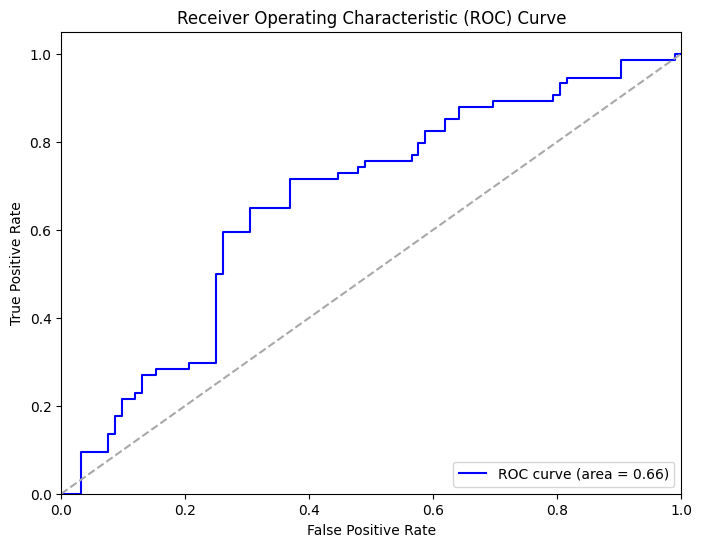

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix

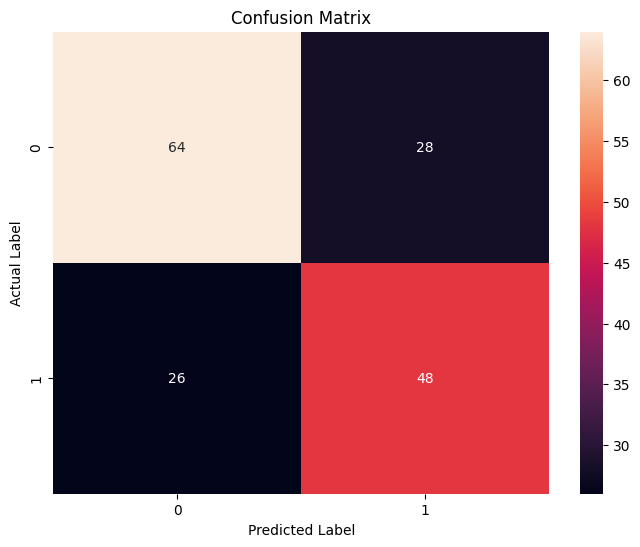

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Precision - Recall

Looking at the precision-recall chart here gives a good picture of the trade off between the two. There is some interesting volatility in the middle of the chart where precision initially dips, and then increases moderately as recall increases before gradually falling. 

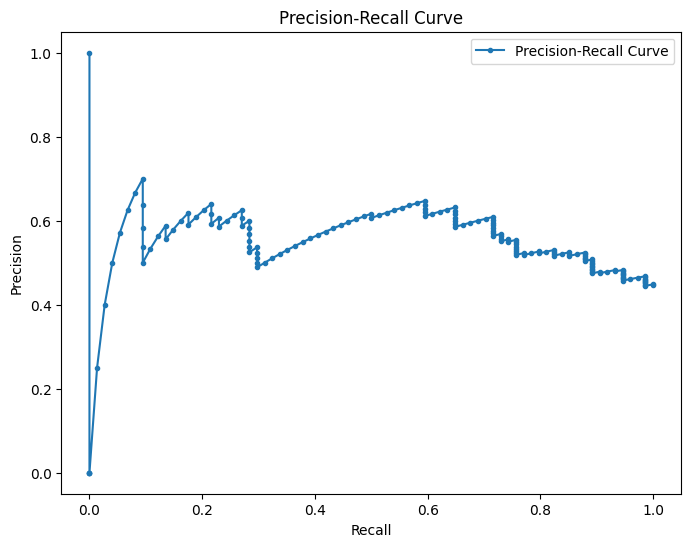

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Learning Curve

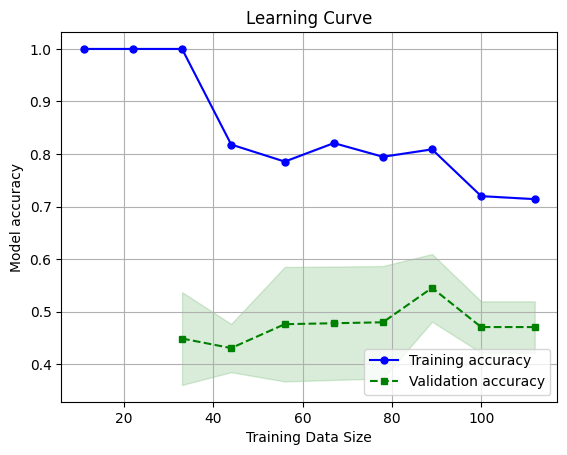

In [17]:
X_train = train_df.drop('post_call_price_direction', axis=1)
y_train = train_df['post_call_price_direction']

# Using time series splits for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,  # make sure the pipeline is fitted if required
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=tscv,  # time series
    scoring='accuracy',
    n_jobs=-1,
    shuffle=False # we don't wnat to shuffle here since it's time series data
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Conclusion

As mentioned throughout this analysis, this has been meant to be a baseline analysis to serve as a comparison during future iterations. There is a lot of information gleaned from companies earnings calls that can be useful in determining a companies valuation. While this has been a simplistic analysis with a basic text process and feature engineering approach, in future approaches I will increase the complexity here and also include the broader market instead of a single industry. Within that context, the analysis here shows that there is some value, though moderately low in predictive ability in it's current form, for predicting the stocks price movement direction based on the transcript sentiment and stock volatility leading up to the call.